## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'

In [3]:
!wget $data

--2021-10-19 11:55:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6,8M) [text/plain]
Saving to: 'AB_NYC_2019.csv.1'

     0K .......... .......... .......... .......... ..........  0%  794K 9s
    50K .......... .......... .......... .......... ..........  1% 2,05M 6s
   100K .......... .......... .......... .......... ..........  2% 1,11M 6s
   150K .......... .......... .......... .......... ..........  2% 3,76M 5s
   200K .......... .......... .......... .......... ..........  3% 1,19M 5s
   250K .......... .......... .......... .......... ..........  4% 3,14M 4s
   300K .......... .......... .......... .......... ..........  5% 7,14M 4s
   350K .......... ...

In [4]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
SEED = 1

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

assert df.shape[0] == df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

In [8]:
df_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Queens,40.76434,-73.92132,Entire home/apt,4,30,0.32,1,363
1,Brooklyn,40.73442,-73.95854,Private room,5,2,0.16,1,0
2,Brooklyn,40.66359,-73.99487,Entire home/apt,1,33,2.75,5,113
3,Brooklyn,40.63766,-74.02626,Private room,3,1,0.12,2,362
4,Brooklyn,40.65118,-74.00842,Private room,2,0,0.00,2,365


Now, use `DictVectorizer` to turn train and validation into matrices:

In [9]:
from sklearn.feature_extraction import DictVectorizer

In [10]:
dv = DictVectorizer(sparse=False)

In [11]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_text

In [13]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [14]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



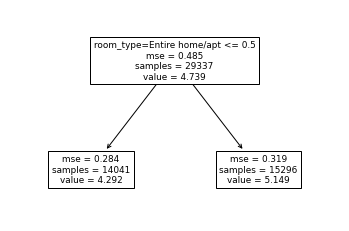

In [15]:
tree.plot_tree(dt, feature_names=dv.get_feature_names());

Which feature is used for splitting the data?

* **`room_type`**
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [17]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
y_pred = rf.predict(X_val)
score = mean_squared_error(y_val, y_pred, squared=False)
print(f'RMSE = {round(score, 3)}')

RMSE = 0.462


Choose the closest one.

What's the RMSE of this model on validation?

* 0.059
* 0.259
* **0.459**
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [19]:
from tqdm import tqdm

In [20]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    scores.append((n, rmse))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.62s/it]


In [21]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

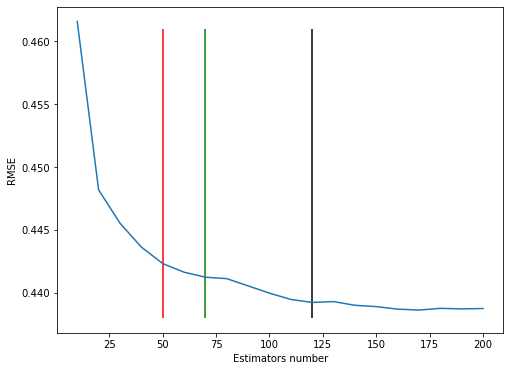

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.vlines(50, 0.438, 0.461, color='red')
plt.vlines(70, 0.438, 0.461, color='green')
plt.vlines(120, 0.438, 0.461, color='black')
plt.xlabel('Estimators number')
plt.ylabel('RMSE');

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [23]:
def get_tree_best_params(seed: int) -> pd.DataFrame:
    scores = []
    for depth in [10, 15, 20, 25]:
        for n in tqdm(range(10, 201, 10)):
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       random_state=seed,
                                       n_jobs=-1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)

            scores.append((depth, n, rmse))
            
    columns = ['max_depth', 'n_estimators', 'rmse']
    return pd.DataFrame(scores, columns=columns)

In [24]:
df_scores = get_tree_best_params(seed=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.01s/it]


In [25]:
def plot_tree_rmse(df: pd.DataFrame, depth: list):
    plt.figure(figsize=(8, 6))
    for d in depth:
        df_subset = df_scores[df_scores.max_depth == d]
        plt.plot(df_subset.n_estimators, df_subset.rmse,
                 label=f'max_depth={d}')

    plt.xlabel('Estimators number')
    plt.ylabel('RMSE');
    plt.legend();

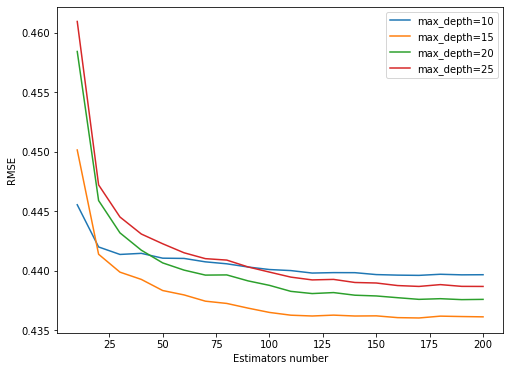

In [26]:
max_depth = [10, 15, 20, 25]
plot_tree_rmse(df_scores, max_depth)

What's the best `max_depth`:

* 10
* **15**
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Guess, it won't affect. Each tree in our RF trains on the subsample of data. So, as far we increase the number of estimators, as the more stable results we get.

Let's check it.

In [27]:
df_scores = get_tree_best_params(seed=42)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.19s/it]


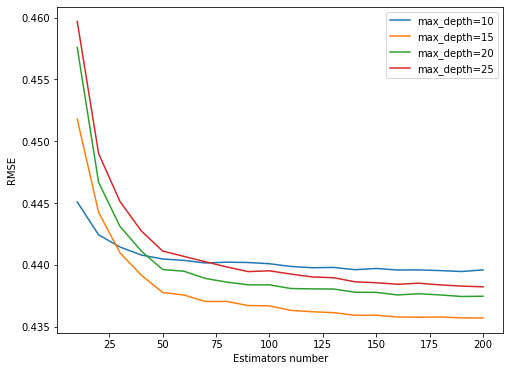

In [28]:
max_depth = [10, 15, 20, 25]
plot_tree_rmse(df_scores, max_depth)

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [29]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [30]:
data = {
    'feature_names': dv.get_feature_names(),
    'feature_importance': rf.feature_importances_
}

fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
fi_df

,feature_names,feature_importance
12,room_type=Entire home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430
4,minimum_nights,0.053252
10,number_of_reviews,0.041594
7,neighbourhood_group=Manhattan,0.034047
1,calculated_host_listings_count,0.030102
14,room_type=Shared room,0.005023


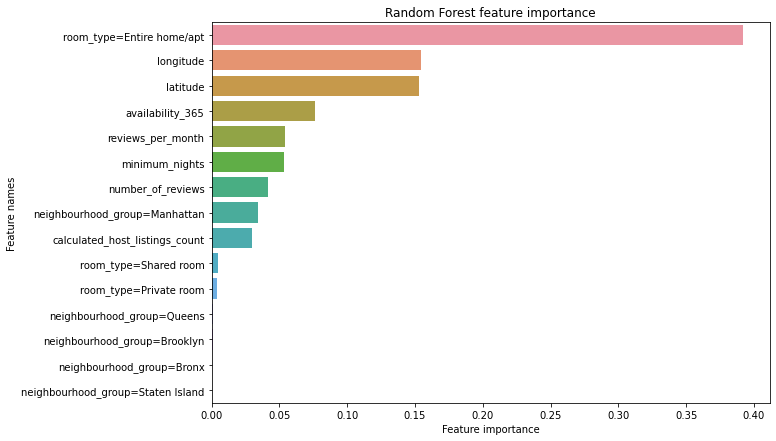

In [31]:
plt.figure(figsize=(10, 7))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('Random Forest feature importance')
plt.xlabel('Feature importance')
plt.ylabel('Feature names');

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* **`room_type=Entire home/apt`**
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [32]:
!pip install xgboost

In [33]:
import xgboost as xgb

In [34]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [35]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [36]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [37]:
scores = {}

In [43]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1,
                  evals=watchlist)

Now change `eta` first to `0.1` and then to `0.01`

In [44]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

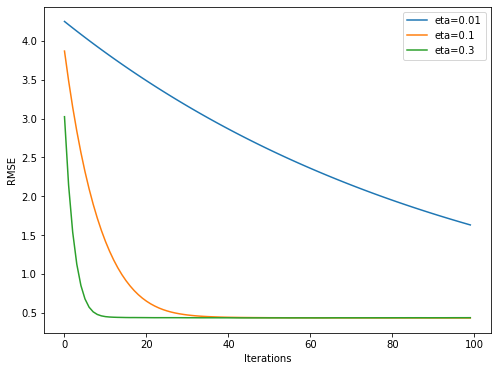

In [45]:
plt.figure(figsize=(8, 6))
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend();

Which eta leads to the best RMSE score on the validation dataset?

* **0.3**
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

